<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/M2_Global_Innovation_Bipartite_v2_qmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Uncovering the Hidden Networks of Global Innovation

Welcome! In this tutorial, we will act as data scientists to reveal the hidden collaboration structures in patent data. We'll discover not only who the key inventors are, but also how entire countries interact in the global innovation landscape.

Our primary tool is the **bipartite network**, which models relationships between two different types of entities. The core idea is that **networks reveal the *structure* of relationships, unlocking insights that are invisible in simple tables or spreadsheets.**

### Our Exploration Plan:

*   **Part 1: The Micro-Network of Inventors**
    1.  Setup & Data Loading
    2.  Build the `Inventor ↔ Application` Bipartite Graph
    3.  **Two-Mode Analysis:** Discovering insights only visible in the bipartite structure.
    4.  **The One-Mode Projection:** Understanding what projection is, why we do it, and what it reveals about `Inventor-Inventor` collaborations.
    5.  **One-Mode Analysis:** Finding "brokers" and hidden communities.

*   **Part 2: The Macro-Network of Countries**
    6.  Build the `Country ↔ Application` Bipartite Graph
    7.  Project to create the `Country-Country` Collaboration Network
    8.  Discovering the "degrees of separation" between nations.

*   **Part 3: Visualization**
    9.  Create interactive plots to explore our Micro and Macro networks.

---
# Part 1: The Micro-Network of Inventors

## 1. Setup & Data Loading
First, we load our Python libraries and the dataset. Each row represents a single inventor's contribution to a single patent application.

In [1]:
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/data/epo_inventors_clean.csv', low_memory=False, encoding='latin-1')

# Prepare data types for NetworkX
df["appln_id"] = df["appln_id"].astype(str)
df["person_id"] = df["person_id"].astype(str)
df["ctry_code"] = df["ctry_code"].astype(str)

df.head()

,app_nbr,appln_id,pub_nbr,person_id,inv_name,address,city,postal_code,reg_code,ctry_code,reg_share,inv_share
0,EP20200150332,524471176,3846498,69775855,"VENDELBO, Allan Munk","c/o GN Hearing A/S, Att: Group IPR,Lautrupbjer...",Ballerup,2750,DK012,DK,1,1.00
1,EP20200150357,524471215,3846066,69746744,"BRÃDSGAARD, Martin","MÃ¸llevangen 4,8382 Hinnerup",NaN,8382,DK042,DK,1,0.25
2,EP20200150357,524471215,3846066,74442350,"SÃRENSEN, SÃ¸ren Hove","ElgÃ¥rdsminde 125,8382 Hinnerup",NaN,8382,DK042,DK,1,0.25
3,EP20200150357,524471215,3846066,79429609,"YVES DEBRUYNE, Yannick","Rua da Cruz, 319, 3Âº Andar,4200-248 Porto",Porto,4200,PT11A,PT,1,0.25
4,EP20200150357,524471215,3846066,79475544,"SEAWARD, James","c/o Vestas Patents Department,Hedeager 42,8200...",Aarhus,8200,DK042,DK,1,0.25


## 2. Build the `Inventor ↔ Application` Bipartite Graph
A bipartite graph is the most accurate model of our data's raw structure. We have two types of nodes—inventors and applications—and an edge only connects an inventor to an application they worked on.

We will use a `bipartite=0` attribute for inventors and `bipartite=1` for applications.

In [2]:
# Create an empty graph
B_inv = nx.Graph()

# Add inventor nodes with attributes (bipartite=0)
inventor_attrs = df.groupby("person_id").agg(
    inv_name=("inv_name", "first"),
    ctry_code=("ctry_code", "first")
).reset_index()
for _, r in inventor_attrs.iterrows():
    B_inv.add_node(r["person_id"], bipartite=0, type="inventor", name=r["inv_name"], country=r["ctry_code"])

# Add application nodes with attributes (bipartite=1)
app_attrs = df.groupby("appln_id").agg(pub_nbr=("pub_nbr", "first")).reset_index()
for _, r in app_attrs.iterrows():
    B_inv.add_node(r["appln_id"], bipartite=1, type="application", pub_nbr=r["pub_nbr"])

# Add edges between inventors and applications
edges_to_add = df[["person_id", "appln_id"]].dropna().drop_duplicates()
B_inv.add_edges_from([tuple(x) for x in edges_to_add.values])

print("Bipartite Inventor-Application Graph created.")
print(f"It has {B_inv.number_of_nodes()} total nodes and {B_inv.number_of_edges()} edges.")

Bipartite Inventor-Application Graph created.
It has 6377 total nodes and 6194 edges.


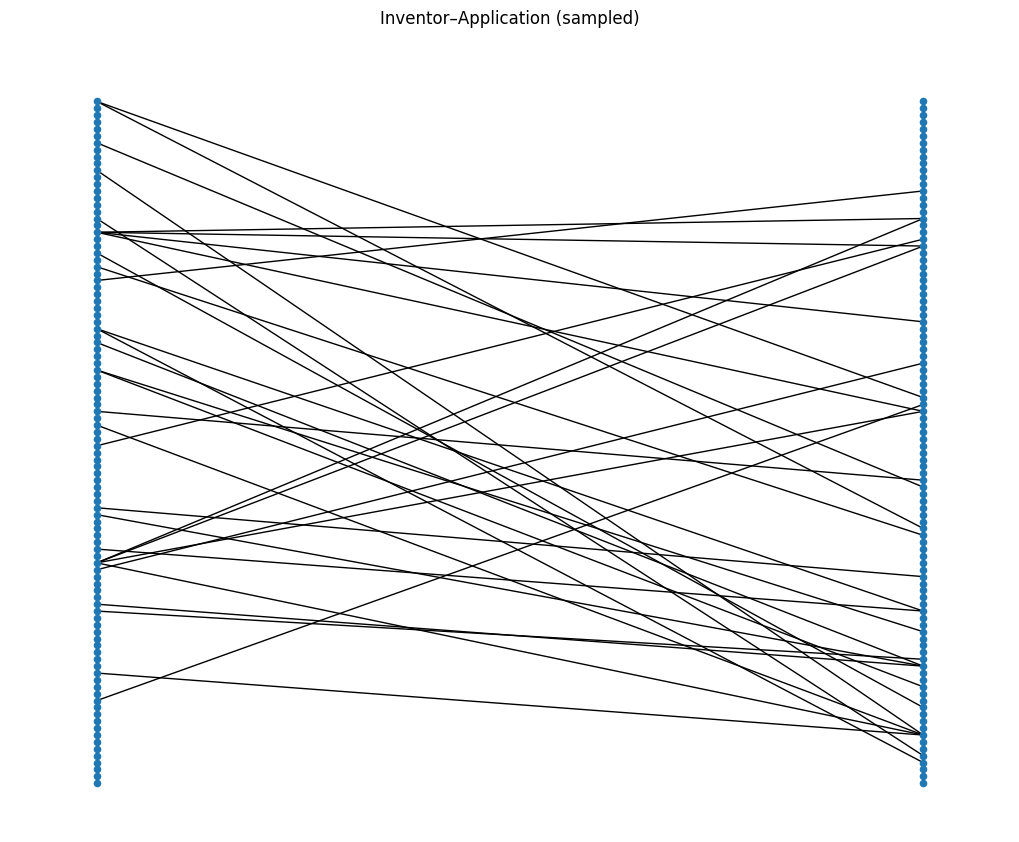

In [3]:
# Take up to 100 inventors and 100 applications for a quick snapshot
apps = [n for n, d in B_inv.nodes(data=True) if d.get("bipartite") == 1]
inventors = [n for n, d in B_inv.nodes(data=True) if d.get("bipartite") == 0]
sample_inventors = list(inventors)[:100]
sample_apps = apps[:100]
H = B_inv.subgraph(sample_inventors + sample_apps).copy()

# Need to separate nodes by bipartite attribute for layout
top_nodes = [n for n in H.nodes() if H.nodes[n]['bipartite'] == 0]
bottom_nodes = [n for n in H.nodes() if H.nodes[n]['bipartite'] == 1]


pos_H = nx.bipartite_layout(H, nodes=top_nodes)
plt.figure(figsize=(10, 8))
nx.draw(H, pos_H, node_size=20, with_labels=False)
plt.title("Inventor–Application (sampled)")
plt.axis("off")
plt.show()

## 3. Two-Mode Analysis: The Bipartite Advantage

Before we project the graph, we can analyze its bipartite structure directly. This reveals insights that matrix-based shortcuts or simple `groupby` operations miss.

### Insight 1: Team Size as Node Degree
A `groupby` operation can count inventors per application, but the network-native way is to calculate the **degree of the application nodes**.

In [4]:
application_nodes = [n for n, d in B_inv.nodes(data=True) if d.get("bipartite") == 1]
team_size = pd.Series({app: B_inv.degree(app) for app in application_nodes}).sort_values(ascending=False)

print("Top 5 Largest Teams (by Application Node Degree):")
print(team_size.head())

Top 5 Largest Teams (by Application Node Degree):
556448026    18
549805183    16
554312956    14
545711550    12
549931858    12
dtype: int64


### Insight 2: Finding "Bridge" Applications (Impossible with `groupby`)
Which patent was most critical for bringing together *otherwise disconnected* groups of inventors? This is a "bridge" patent. We find this using **bipartite betweenness centrality**.

**Why `groupby` fails:** A `groupby` can find the biggest team, but it can't tell you if that team was just one pre-existing group. A patent with high centrality might have a smaller team, but its members could be from vastly different research clusters.

In [5]:
from networkx.algorithms import bipartite

# Calculate centrality on the bipartite graph
# This finds the importance of BOTH inventors and applications as connectors
centrality = bipartite.betweenness_centrality(B_inv, nodes=[n for n,d in B_inv.nodes(data=True) if d.get('bipartite')==0])

# Filter for just the application nodes and find the top ones
app_centrality = {node: score for node, score in centrality.items() if node in application_nodes}
top_bridge_apps = pd.Series(app_centrality).sort_values(ascending=False)

print("\nTop 5 'Bridge' Applications (most important for connecting diverse inventors):")
print(top_bridge_apps.head())


Top 5 'Bridge' Applications (most important for connecting diverse inventors):
561368299    0.000165
560469524    0.000147
538882629    0.000143
569111827    0.000130
572789893    0.000119
dtype: float64


**Interpretation:** An application with a high centrality score, even if its team size isn't the largest, represents a significant cross-pollination of ideas and expertise.

## 4. The One-Mode Projection: Creating the Social Network

Now, we will create the `Inventor-Inventor` social network. To do this, we **project** the bipartite graph.

### 🔍 Analysis & Questions
1.  **What is projection?**
    Projection is the process of converting an *indirect* relationship into a *direct* one. In our bipartite graph, two inventors are only connected indirectly *through* a patent they share. Projection creates a new graph with only inventors, drawing a direct edge between any two who collaborated.

2.  **Why do we need to project?**
    Standard social network metrics like "who is the biggest broker?" or "what are the hidden communities?" are designed for one-mode networks (where all nodes are of the same type). We must first create this social network to be able to analyze it.

3.  **What information is lost during projection?**
    The specific `appln_id` that connected two inventors is collapsed into the edge. The edge's `weight` tells us *how many* patents they shared, but not *which ones*. This is why analyzing the bipartite graph first (Step 3) is so important!

In [6]:
# Select only the inventor nodes
inventor_nodes = [n for n, d in B_inv.nodes(data=True) if d.get("bipartite") == 0]

# Project the bipartite graph onto the inventor nodes
G_inv = nx.bipartite.weighted_projected_graph(B_inv, inventor_nodes)

print("\nInventor-Inventor one-mode graph created.")
print(f"It has {G_inv.number_of_nodes()} nodes and {G_inv.number_of_edges()} edges (collaborations).")


Inventor-Inventor one-mode graph created.
It has 4276 nodes and 8209 edges (collaborations).



## 5. One-Mode Analysis: The Power of Projection

With our `Inventor-Inventor` social network, we can now answer questions that are impossible with simple tabular data.

### Insight 1: Finding "Knowledge Brokers (Gatekeepers)" (Impossible with `groupby`)
Who are the crucial individuals connecting different research communities? We find them with **betweenness centrality**.

**Why `groupby` fails:** `groupby` can count an inventor's direct collaborators. It cannot see the entire map of connections to know who serves as a vital bridge between two otherwise separate groups.

In [7]:
# Calculate betweenness centrality on the projected graph
betweenness = nx.betweenness_centrality(G_inv, k=min(500, len(G_inv)), seed=42) # Use a sample for speed
top_brokers = pd.Series(betweenness).sort_values(ascending=False)

print("\nTop 10 Inventor 'Brokers' (by Betweenness Centrality):")
print(top_brokers.head(10))


Top 10 Inventor 'Brokers' (by Betweenness Centrality):
83215715    0.000389
81622266    0.000386
83235289    0.000375
81666152    0.000370
81657420    0.000307
81686928    0.000144
81665536    0.000124
88855829    0.000121
81677012    0.000106
81657824    0.000104
dtype: float64


### Insight 2: Discovering "Invisible Colleges" (Impossible with `groupby`)
Can we find emergent clusters of inventors who collaborate frequently, regardless of their country or company? We use **community detection**.

**Why `groupby` fails:** You can `groupby('city')` or `groupby('country')`, but this only shows pre-defined groups. It cannot *discover* a hidden, international cluster of specialists who all work in the same niche.

In [8]:
import community.community_louvain as community_louvain

In [9]:
# Find communities using the Louvain algorithm
partition = community_louvain.best_partition(G_inv)
communities = pd.Series(partition)

print("\nFound {communities.nunique()} hidden communities.")
print("Top 10 Largest Communities:")
print(communities.value_counts().head(10))


Found {communities.nunique()} hidden communities.
Top 10 Largest Communities:
225    175
34      66
190     56
226     42
178     37
709     35
339     29
43      28
249     27
237     24
Name: count, dtype: int64



# Part 2: The Macro-Network of Countries

Now we zoom out. By applying the *exact same techniques*, we can build a network of countries to understand international collaboration.

## 6. Build the `Country ↔ Application` Bipartite Graph
Here, nodes are either countries or applications. An edge means a country had at least one inventor on that patent.

In [10]:
B_country = nx.Graph()

# Add country nodes (bipartite=0)
df_clean = df.dropna(subset=['ctry_code'])
country_nodes_list = df_clean["ctry_code"].unique()
B_country.add_nodes_from(country_nodes_list, bipartite=0, type="country")

# Add application nodes (bipartite=1)
app_nodes_list = df_clean["appln_id"].unique()
B_country.add_nodes_from(app_nodes_list, bipartite=1, type="application")

# Add edges
country_edges = df_clean[["ctry_code", "appln_id"]].drop_duplicates()
B_country.add_edges_from([tuple(x) for x in country_edges.values])

print("\nBipartite Country-Application Graph created.")


Bipartite Country-Application Graph created.



### 1. Which Applications are the Most International?

In the context of this graph, an "international" application is one that connects many different countries.

*   **The Question:** "Which patent applications represent the largest international collaborations, measured by the number of distinct countries involved?"

*   **How the Network Answers It:**
This is simply the **degree of the application nodes**. The degree of a node is the number of edges connected to it. For an application node in `B_country`, its degree is the number of countries whose inventors contributed to it.

*   **Why `groupby` is Clumsy:** You *could* do this with `df.groupby('appln_id')['ctry_code'].nunique()`. However, thinking in terms of the network model ("application node degree") is a more powerful concept that leads to further network-specific analysis.

In [11]:
# First, get a list of all nodes that are applications
application_nodes = [n for n, d in B_country.nodes(data=True) if d.get("bipartite") == 1]

# Calculate the degree of each application and store it in a Series
international_collaboration_counts = pd.Series(
    {app_id: B_country.degree(app_id) for app_id in application_nodes}
).sort_values(ascending=False)

print("Top 10 Most International Applications (by number of countries involved):")
print(international_collaboration_counts.head(10))

# You could find an application with a degree of 5, meaning it brought together inventors from 5 different nations.

Top 10 Most International Applications (by number of countries involved):
566649004    5
553380840    5
551348271    5
548235870    5
569426076    5
547139982    4
547139815    4
565076586    4
539597760    4
534928523    4
dtype: int64


### 2. Which Countries Have the Most Diverse Patent Portfolio?

This question looks at the other side of the network: the country nodes.

**The Question:** "Which countries are involved in the highest number of distinct patent applications in this dataset?"

**How the Network Answers It:**
This is the **degree of the country nodes**. For a country node in `B_country`, its degree is the number of unique applications its inventors have contributed to.

In [12]:
# Get a list of all nodes that are countries
country_nodes = [n for n, d in B_country.nodes(data=True) if d.get("bipartite") == 0]

# Calculate the degree of each country node
country_portfolio_size = pd.Series(
    {country: B_country.degree(country) for country in country_nodes}
).sort_values(ascending=False)

print("\nTop 10 Countries with the Most Diverse Patent Involvement:")
print(country_portfolio_size.head(10))


Top 10 Countries with the Most Diverse Patent Involvement:
DK    2101
US     124
DE     122
FI      80
GB      59
IN      43
SE      36
FR      35
NL      35
CH      24
dtype: int64


**Interpretation:** This gives you a quick ranking of which countries have the broadest innovative "reach" within this dataset.

### 3. Which Countries are "Structural Bridges" in Global Innovation? (Insight `groupby` CANNOT provide)

This is the most powerful question you can answer at this stage. A bridge country isn't necessarily the one with the highest degree. It's a country that is critical for connecting *other* countries that do not collaborate directly. It acts as a global innovation hub.

**The Question:** "Which country is most essential for connecting different technological or regional clusters? If it were removed, which removal would most fracture the global innovation network?"

**How the Network Answers It:**
By calculating the **betweenness centrality of the country nodes** within the bipartite graph. This metric measures how many of the shortest paths between application nodes pass through a given country node. A high score indicates that the country is a crucial intermediary.

**Why `groupby` Fails:** Tabular methods are completely blind to the concept of "paths" and "intermediaries." They can count direct co-occurrences but cannot understand the overall topology or flow of the network.


In [13]:
from networkx.algorithms import bipartite

# For centrality, the paths are calculated between one set of nodes (e.g., applications)
# and we measure which nodes in the OTHER set (countries) lie on those paths.
centrality = bipartite.betweenness_centrality(B_country, nodes=application_nodes)

# Filter the results to show only the centrality scores for countries
bridge_country_scores = pd.Series(
    {node: score for node, score in centrality.items() if node in country_nodes}
).sort_values(ascending=False)

print("\nTop 10 'Bridge' Countries (by Bipartite Centrality):")
print(bridge_country_scores.head(10))


Top 10 'Bridge' Countries (by Bipartite Centrality):
DK    0.994152
US    0.001881
DE    0.001722
FI    0.000741
GB    0.000382
IN    0.000208
SE    0.000146
FR    0.000139
NL    0.000133
CH    0.000063
dtype: float64


**Interpretation:** You might find that a country like Denmark (`DK`) has a very high centrality score. This would suggest that Denmark plays a critical role in connecting, for example, innovation happening in the US with innovation happening in Germany, making it a strategic hub.

## 7. Project to Create the `Country-Country` Network
Projecting this graph gives us a network where countries are nodes and an edge represents a shared patent. The **edge weight is the number of co-authored patents**, a direct measure of partnership strength.

In [14]:
country_nodes = [n for n, d in B_country.nodes(data=True) if d.get("bipartite") == 0]
G_country = nx.bipartite.weighted_projected_graph(B_country, country_nodes)

print("\nCountry-Country one-mode graph created.")


Country-Country one-mode graph created.


## 8. One-Mode Macro Analysis

### Insight 1: Finding the Strongest International Partnerships
We can easily find the strongest bilateral relationships by sorting the edges by their weight.

In [15]:
# Sort edges by weight to find strongest partnerships
strongest_partnerships = sorted(G_country.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

print("\nTop 10 Strongest International Collaboration Pairs:")
for u, v, data in strongest_partnerships[:10]:
    print(f"- {u}-{v}: {data['weight']} shared patents")


Top 10 Strongest International Collaboration Pairs:
- DK-US: 124 shared patents
- DK-DE: 122 shared patents
- DK-FI: 80 shared patents
- DK-GB: 59 shared patents
- DK-IN: 43 shared patents
- DK-SE: 36 shared patents
- DK-NL: 35 shared patents
- DK-FR: 35 shared patents
- DK-CH: 24 shared patents
- DK-CN: 22 shared patents



### Insight 2: Finding the "Degrees of Separation" Between Countries (Impossible with `groupby`)
Your data shows collaborations between `DK-PT` and `DK-JP`, but none directly between `PT-JP`. How are they connected? A tabular query would show "0", but network analysis can find the path.

**Why `groupby` fails:** `groupby` cannot trace multi-step connections. The network graph, however, sees the entire map.

In [16]:
try:
    path = nx.shortest_path(G_country, source='PT', target='JP')
    print(f"\nShortest collaboration path between Portugal (PT) and Japan (JP):")
    print(" -> ".join(path))
except nx.NetworkXNoPath:
    print("\nNo collaboration path found between PT and JP.")


Shortest collaboration path between Portugal (PT) and Japan (JP):
PT -> DK -> JP


**Interpretation:** This reveals that Denmark (`DK`) acts as a crucial bridge in the flow of innovation between Portugal and Japan in this dataset.



### Summary

Your `B_country` object is not just a stepping stone. It is a rich model that allows you to:
1.  **Quantify the international scope** of individual patents.
2.  **Measure the innovative breadth** of individual countries.
3.  **Discover the structurally important "bridge" countries** that are central to the global flow of innovation, an insight unique to network analysis.

# Part 3: Visualization

## 9. Create Interactive Plots
Finally, we use `pyvis` to create interactive HTML files to explore these two different networks.

### Micro-Network: The Largest Inventor Team
This shows the bipartite structure of the single largest team. Green dots are inventors, the blue box is the patent.

In [17]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.7 MB/s eta 0:00:00


In [18]:
# Build a styled copy of the full bipartite graph
H_all = B_inv.copy()
for n, d in H_all.nodes(data=True):
    if d.get("type") == "application":
        d["label"] = d.get("pub_nbr", str(n))
        d["shape"] = "box"
        d["color"] = "#6baed6"
        d["title"] = f"Application ID: {n}"
        d["group"] = "application"
    else:  # inventor
        d["label"] = d.get("name", str(n))
        d["shape"] = "dot"
        d["color"] = "#31a354"
        d["title"] = f"Inventor: {d.get('name','?')}<br>Country: {d.get('country','?')}"
        d["group"] = "inventor"

from pyvis.network import Network

net = Network(height="800px", width="100%", notebook=False, cdn_resources="in_line")
net.from_nx(H_all)  # pulls labels/colors/shapes/titles/groups from node attributes

# Keep the defaults lightweight but interactive
net.set_options("""
{
  "nodes": { "size": 8 },
  "edges": { "smooth": false, "color": {"opacity": 0.3} },
  "interaction": { "hover": true, "tooltipDelay": 100 },
  "physics": {
    "solver": "barnesHut",
    "stabilization": { "iterations": 200 }
  }
}
""")

net.write_html("inventor_application_network.html")
print("Saved to inventor_application_network.html")


Saved to inventor_application_network.html


### Macro-Network: The Global Collaboration Web
This shows the `Country-Country` network. Node size represents total collaborations and edge thickness represents partnership strength.


In [19]:
G_country.nodes

NodeView(('DK', 'PT', 'DE', 'JP', 'CH', 'SE', 'US', 'GB', 'EG', 'IN', 'FI', 'KR', 'ES', 'PL', 'RU', 'NL', 'FR', 'NO', 'CZ', 'SK', 'IE', 'AT', 'CN', 'BE', 'TH', 'TW', 'ZA', 'CA', 'AU', 'UA', 'MY', 'SG', 'QA', 'IT', 'HK', 'IS', 'IL', 'TR', 'BR', 'EE', 'DO'))

In [20]:
from pyvis.network import Network
import networkx as nx

# ---- 1) Start from a lightly filtered graph (keeps structure but removes hairlines)
MIN_W = 2  # raise if still too busy
H = G_country.edge_subgraph(
    [(u, v) for u, v, w in G_country.edges(data="weight") if (w or 0) >= MIN_W]
).copy()

# ---- 2) Node sizes (weighted degree)
deg = dict(H.degree(weight="weight"))
nx.set_node_attributes(H, {n: (deg.get(n, 0) * 0.05 + 5) for n in H.nodes}, "size")

# Optional: show labels only for top-K hubs
K = 20
top = set(sorted(deg, key=deg.get, reverse=True)[:K])

# (Optional) community coloring for visual separation
try:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = list(greedy_modularity_communities(H, weight="weight"))
    group_map = {n: i for i, c in enumerate(comms) for n in c}
    nx.set_node_attributes(H, group_map, "group")
except Exception:
    pass  # fine if community detection isn't available

# ---- 3) Build PyVis
net = Network(height="850px", width="100%", notebook=False, cdn_resources="in_line")

# Add nodes with cleaner labels & tooltips
for n, d in H.nodes(data=True):
    net.add_node(
        n,
        label=str(n) if n in top else "",            # hide most labels to avoid overlap
        title=f"Country: {n}<br>Total collaborations: {deg.get(n,0)}",
        size=d.get("size", 10),
        group=d.get("group", None),
    )

# Add edges (value controls thickness)
for u, v, data in H.edges(data=True):
    w = data.get("weight", 1)
    net.add_edge(u, v, value=w, title=f"{w} collaborations")

# ---- 4) Layout/physics: strong spacing + overlap avoidance + deterministic seed
net.set_options("""
{
  "layout": { "randomSeed": 42, "improvedLayout": true },
  "nodes": { "shape": "dot" },
  "edges": { "smooth": false, "color": { "opacity": 0.35 }, "scaling": { "min": 1, "max": 8 } },
  "interaction": { "hover": true, "tooltipDelay": 120 },
  "physics": {
    "enabled": true,
    "solver": "repulsion",
    "repulsion": {
      "nodeDistance": 260,
      "centralGravity": 0.01,
      "springLength": 220,
      "springConstant": 0.02,
      "damping": 0.4
    },
    "stabilization": { "iterations": 400 }
  }
}
""")

net.write_html("macro_country_network.html")
print("Saved to macro_country_network.html")


Saved to macro_country_network.html


### 🚀 Your Turn to Explore!
Open the two generated HTML files.
*   In the **micro** plot, who are the inventors on the largest team? Are they from the same country?
*   In the **macro** plot, which country is the most central? Drag the nodes around to see the structure. Which partnerships are surprisingly strong or weak?